# Book Recommendation System

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/FastAI-Code-Collection/blob/v1/Book_Recommendation_System.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/FastAI-Code-Collection/blob/v1/Book_Recommendation_System.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [1]:
!pip install fastai==1.0.61

In [2]:
from fastai.collab import *

In [3]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 5.3MB 7.0MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 112kB 53.2MB/s 
     |████████████████████████████████| 133kB 53.0MB/s 


In [4]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "<username>" 
os.environ['KAGGLE_KEY'] = "<key>"

In [5]:
path = Config.data_path()/'goodbooks'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/goodbooks')

In [6]:
! kaggle datasets download zygmunt/goodbooks-10k -p "{path}" --unzip 

 43% 5.00M/11.6M [00:00<00:00, 25.7MB/s]
100% 11.6M/11.6M [00:00<00:00, 38.7MB/s]


In [7]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [8]:
books = pd.read_csv(path/'books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [9]:
book_ratings = ratings.merge(books[['id', 'title']], left_on='book_id', right_on='id')
book_ratings.head()

,book_id,user_id,rating,id,title
0,1,314,5,1,"The Hunger Games (The Hunger Games, #1)"
1,1,439,3,1,"The Hunger Games (The Hunger Games, #1)"
2,1,588,5,1,"The Hunger Games (The Hunger Games, #1)"
3,1,1169,4,1,"The Hunger Games (The Hunger Games, #1)"
4,1,1185,4,1,"The Hunger Games (The Hunger Games, #1)"


In [10]:
book_ratings.rating.min(), book_ratings.rating.max()

(1, 5)

In [11]:
data = CollabDataBunch.from_df(book_ratings, seed=42, valid_pct=0.1, user_name='user_id', item_name='title', rating_name='rating')

In [12]:
data.show_batch()

user_id,title,target
28214,"Endless Knight (The Arcana Chronicles, #2)",4.0
28540,The Scarlet Pimpernel,4.0
8291,Day Watch (Watch #2),4.0
7378,On Death and Dying,5.0
11466,Term Limits,5.0


## EmbeddingDotBias Model

In [13]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")

In [14]:
print(learn.summary())

EmbeddingDotBias
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [40]                 2,134,040  True      
______________________________________________________________________
Embedding            [40]                 398,600    True      
______________________________________________________________________
Embedding            [1]                  53,351     True      
______________________________________________________________________
Embedding            [1]                  9,965      True      
______________________________________________________________________

Total params: 2,595,956
Total trainable params: 2,595,956
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 



epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


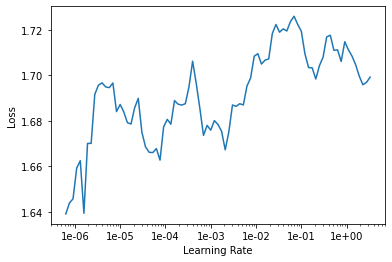

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,time
0,1.593840,1.588148,01:29
1,1.291657,1.308263,01:29
2,1.110527,1.118667,01:29
3,1.011457,1.054282,01:29
4,1.009937,1.044943,01:27


In [17]:
learn.save('goodbooks-dot-1')

## EmbeddingNN Model

In [18]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(1, 5))

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


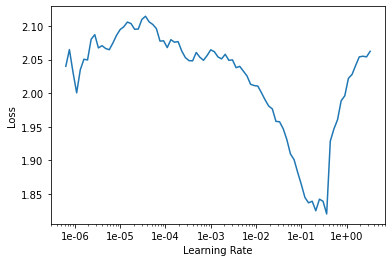

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.778948,0.768653,01:55
1,0.692482,0.753496,01:55
2,0.729247,0.726696,01:55
3,0.670343,0.706217,01:55
4,0.617566,0.710066,01:55


In [21]:
learn.save('goodbooks-nn-1')

## Interpretation

In [22]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")
learn.load('goodbooks-dot-1');

In [23]:
g = book_ratings.groupby('title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books[:10]

array(['Selected Poems', 'Stone Soup', 'Invisible', 'The List', 'Selected Stories',
       'Between the Lines (Between the Lines, #1)', 'The Collected Poems', 'The Complete Stories and Poems', 'Bambi',
       'Are You My Mother?'], dtype=object)

## Book Bias

In [24]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(53351, 40)
  (i_weight): Embedding(9965, 40)
  (u_bias): Embedding(53351, 1)
  (i_bias): Embedding(9965, 1)
)

In [25]:
book_bias = learn.bias(top_books, is_item=True)

In [26]:
mean_ratings = book_ratings.groupby('title')['rating'].mean()
book_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_books, book_bias)]

In [27]:
item0 = lambda o:o[0]

In [28]:
sorted(book_ratings, key=item0)[:15]

[(tensor(-0.0661), 'Lost', 2.74),
 (tensor(-0.0423), 'Her Fearful Symmetry', 2.89),
 (tensor(-0.0377), 'Left Behind (Left Behind, #1)', 2.92),
 (tensor(-0.0201), 'How to Be Good', 2.99),
 (tensor(-0.0075), 'Hausfrau', 2.98),
 (tensor(-0.0073), 'Message in a Bottle', 3.11),
 (tensor(-0.0061), "I Don't Know How She Does It", 3.05),
 (tensor(-0.0059), 'I Am Having So Much Fun Here Without You', 3.01),
 (tensor(-0.0035), 'Labyrinth (Languedoc, #1)', 3.11),
 (tensor(-0.0022), 'Mirror Mirror', 3.18),
 (tensor(-0.0007), 'Men Are from Mars, Women Are from Venus', 3.25),
 (tensor(0.0005), 'Heart of Darkness', 3.34),
 (tensor(0.0010), 'House', 3.12),
 (tensor(0.0020), 'Hush, Hush (Hush, Hush, #1)', 3.21),
 (tensor(0.0060), 'Mad About the Boy (Bridget Jones, #3)', 3.16)]

In [29]:
sorted(book_ratings, key=item0, reverse=True)[:15]

[(tensor(0.4192), 'Selected Poems', 4.08),
 (tensor(0.3921), 'The Complete Stories', 4.32),
 (tensor(0.3720), 'Stone Soup', 4.206666666666667),
 (tensor(0.3586), 'The Collected Poems', 4.17),
 (tensor(0.3577), "One Flew Over the Cuckoo's Nest", 4.276923076923077),
 (tensor(0.3481), 'The Complete Poems', 4.165),
 (tensor(0.3317), 'The Son', 4.03),
 (tensor(0.3296), 'Anatomy for the Artist', 4.121387283236994),
 (tensor(0.3287), 'Selected Stories', 4.145),
 (tensor(0.3239), 'Locke & Key, Vol. 5: Clockworks', 4.66),
 (tensor(0.3194),
  "It's a Magical World: A Calvin and Hobbes Collection",
  4.75),
 (tensor(0.3085),
  'Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)',
  4.77),
 (tensor(0.3046), 'Harry Potter Collection (Harry Potter, #1-6)', 4.72),
 (tensor(0.3042), 'The Complete Stories and Poems', 4.255),
 (tensor(0.3034), 'Jesus the Christ', 4.67)]

In [30]:
book_w = learn.weight(top_books, is_item=True)
book_w.shape

torch.Size([1000, 40])

In [31]:
book_pca = book_w.pca(3)
book_pca.shape

torch.Size([1000, 3])

In [33]:
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books)]

In [34]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9527), 'Stone Soup'),
 (tensor(0.9311), 'Selected Poems'),
 (tensor(0.8325), 'The Complete Stories'),
 (tensor(0.7789), 'The Complete Stories and Poems'),
 (tensor(0.7459), 'The Collected Poems'),
 (tensor(0.7156), 'Bambi'),
 (tensor(0.6865), "Madeline's Rescue"),
 (tensor(0.6797), 'The Little Mermaid'),
 (tensor(0.6165), 'Selected Stories'),
 (tensor(0.5661), 'The Complete Poems')]

In [35]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.7227), 'Kiss of a Demon King (Immortals After Dark #7)'),
 (tensor(-0.7015), 'Kiss of the Night (Dark-Hunter, #4)'),
 (tensor(-0.6850), 'Midnight Rising (Midnight Breed, #4)'),
 (tensor(-0.6528), 'Lothaire (Immortals After Dark #12)'),
 (tensor(-0.6234), 'Kiss of Crimson (Midnight Breed, #2)'),
 (tensor(-0.5896), 'Lead (Stage Dive, #3)'),
 (tensor(-0.5825), 'Lick (Stage Dive, #1)'),
 (tensor(-0.5752), 'Mine to Possess (Psy-Changeling #4)'),
 (tensor(-0.5692), 'Hit List (Anita Blake, Vampire Hunter #20)'),
 (tensor(-0.5680), 'Midnight Awakening (Midnight Breed, #3)')]

In [38]:
book_comp = [(f, i) for f,i in zip(fac1, top_books)]

In [39]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.5063), 'Lost'),
 (tensor(0.4467), 'How to Be Good'),
 (tensor(0.4301), "I Don't Know How She Does It"),
 (tensor(0.4275), 'Her Fearful Symmetry'),
 (tensor(0.4149), 'Midnight (Warriors: The New Prophecy, #1)'),
 (tensor(0.4091),
  'Love Wins: A Book About Heaven, Hell, and the Fate of Every Person Who Ever Lived'),
 (tensor(0.4063), 'Moonrise (Warriors: The New Prophecy, #2)'),
 (tensor(0.4033), 'Maine'),
 (tensor(0.3932), 'Hush, Hush (Hush, Hush, #1)'),
 (tensor(0.3766), 'Heart of Darkness')]

In [40]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.5869), 'Selected Poems'),
 (tensor(-0.5555), 'Stone Soup'),
 (tensor(-0.4186), 'Magic Breaks (Kate Daniels, #7)'),
 (tensor(-0.4184), 'The Witness'),
 (tensor(-0.4148),
  "Magician: Apprentice  (Raymond E. Feist's Magician: Apprentice #1)"),
 (tensor(-0.4051), 'Magic Bleeds (Kate Daniels, #4)'),
 (tensor(-0.4022), 'Judgment in Death (In Death, #11)'),
 (tensor(-0.3924), 'Lothaire (Immortals After Dark #12)'),
 (tensor(-0.3908), 'Iron Kissed (Mercy Thompson, #3)'),
 (tensor(-0.3889), 'Imitation in Death (In Death, #17)')]

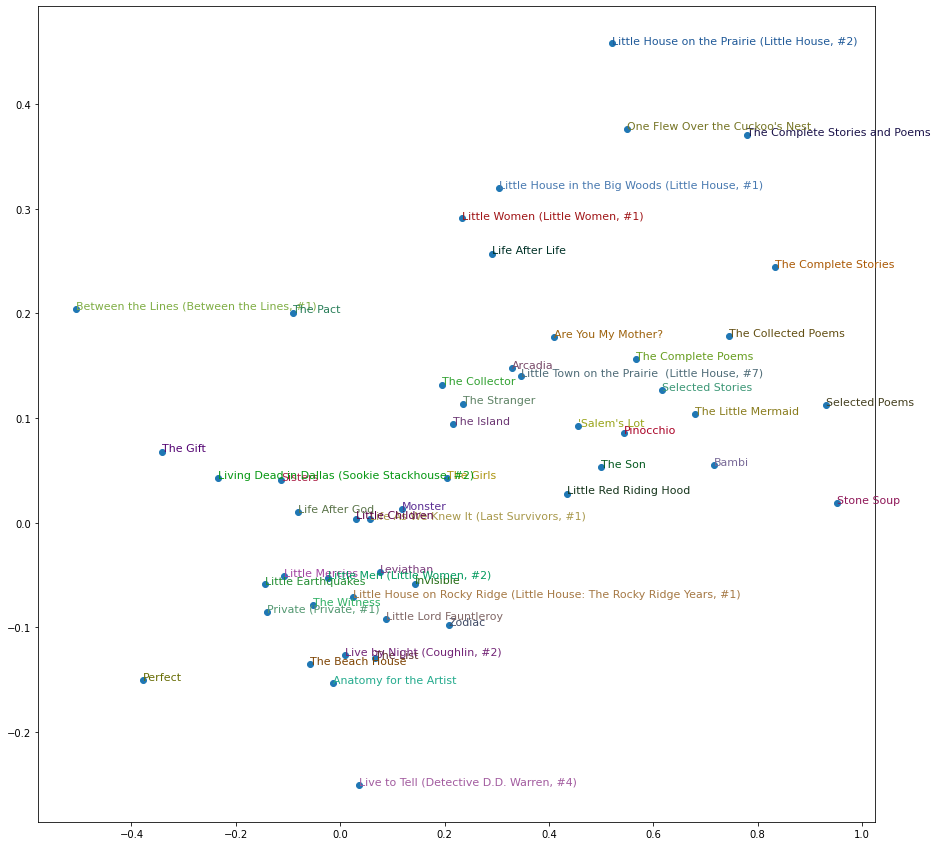

In [42]:
idxs = np.random.choice(len(top_books), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()